In [1]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

## Estimates from Factor Model
We assume a factor model where there are $k$ assets and $T$ time periods (months in our case), m is the common factors (topic weights in our case). $r_{it}$ is the return for asset $i$ at time $t$.

$$
\begin{align}
r_{it}
= &\alpha_i + \sum_{j=1}^{m} \beta_{ij} f_jt + \epsilon_{it}, t = 1, \dots, T, i = 1, \dots, k\\ \\
R_{k \times T} = & B_{k \times m} \cdot coef_{m \times T} + E_{k \times T}
\end{align}
$$

In our analysis, $R_{k \times T}$ is the returns matrix imported, $B_{k \times m}$ is the topic modeling matrix, and $coef_{m \times T}$ is the coefficient matrix computed from the linear regression of returns matrix on topic modeling matrix. $E_{k \times T}$ is the residual matrix.

In our factor model, 

$$\text{Cov}(r) = B \Sigma_{coef} B^T + D, 
\text{ where } D = diag(\sigma^2_1, \dots, \sigma^2_k) \text{ and Var}(\epsilon_i) = \sigma^2_i$$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import string
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
r_selected = pd.read_csv("data/filtered_r.csv")
# get the mean of all 
r_selected.set_index("name", inplace = True)
mu = r_selected.mean(axis = 1)
# compute the covariance matrix 
cov = r_selected.T.cov()

In [4]:
df = pd.read_csv('../data/preprocessed.csv',
                 usecols = ['reportingDate', 'name', 'CIK', 'coDescription',
                           'coDescription_stopwords', 'SIC', 'SIC_desc'])
df = df.set_index(df.name)

### Sent-LDA
We ran the coherence score benchmarking over a range of 3 to 40 topics, incrementing by 3. 

First, we fit the LDA model to all business description using the number of topics selected from coherence score benchmarking. 

Then, we assume each sentence only represents one topic; get the frequency of the topics revealed in the whole document (business description for one company) and calculate the probability of each topics in the whole document. 

#### Coherence Score Plot

![Factor_Model_Coherence_Score.png](images/Factor_Model_Coherence_Score.png)

Based on the above Coherence Score, we choose up to 12 topics since it gives the highest score up to here.

In [5]:
data = df.loc[:,"coDescription_stopwords"].to_list()

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.85, min_df=2, max_features=600)
tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names_out()
lda = LatentDirichletAllocation(n_components=12, random_state=0).fit(tf)

We show the top 10 words by weights in the 12 topics LDA model generates in the below table.

In [7]:
std_func.get_topics(lda, tf_vectorizer, 12)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12
0,could,loan,share,product,investment,gas,hotel,patient,bank,customer,million,cell
1,gas,mortgage,stock,drug,income,oil,facility,treatment,capital,service,tax,cancer
2,regulation,real,note,fda,asset,natural,tenant,trial,institution,data,asset,tumor
3,oil,estate,issued,clinical,reit,production,lease,study,federal,product,net,product
4,future,commercial,preferred,patent,real,reserve,operating,phase,act,solution,income,therapy
5,natural,bank,date,approval,tax,proved,estate,clinical,banking,software,cash,therapeutic
6,price,interest,amount,trial,share,drilling,million,disease,holding,platform,expense,clinical
7,affect,rate,september,application,interest,regulation,real,drug,regulation,technology,value,technology
8,ability,million,per,regulatory,distribution,net,center,therapy,deposit,application,note,research
9,adversely,security,director,candidate,estate,water,portfolio,data,asset,sale,statement,license


#### Frequency of the Topics in Each Sentence

In [8]:
n_components = 12
prob = pd.DataFrame(0, index = df.name, columns = range(n_components))

In [9]:
for j in range(len(df)):
    LIST_sent = pd.Series(df.coDescription[j].split('.')).apply(std_func.lemmatize_sentence).apply(std_func.remove_nums).apply(std_func.remove_stopwords)
    
    X = tf_vectorizer.transform(LIST_sent.tolist())
    sent = lda.transform(X)
    sent_df = pd.DataFrame(sent)
    # drop the values that are smaller than 1/12
    # if the maximum value is 1/12, the probability of each topic in that sentence is the same
    # we cannot determine which topic to choose
    sent_df = sent_df[sent_df.max(axis = 1) > 1/12].reset_index(drop = True)

    for i in range(n_components):
        prob.iloc[j][i] = list(sent_df.idxmax(axis = 1)).count(i)
    
    # calculate the probability
    prob = prob.div(prob.sum(axis=1), axis=0)

In [10]:
prob

,0,1,2,3,4,5,6,7,8,9,10,11
name,,,,,,,,,,,,
"MONGODB, INC.",0.014652,0.007326,0.021978,0.036630,0.018315,0.010989,0.040293,0.021978,0.014652,0.739927,0.047619,0.025641
SALESFORCE COM INC,0.010811,0.010811,0.005405,0.016216,0.000000,0.021622,0.037838,0.005405,0.005405,0.821622,0.054054,0.010811
SPLUNK INC,0.010274,0.003425,0.013699,0.020548,0.013699,0.003425,0.023973,0.000000,0.003425,0.839041,0.058219,0.010274
"OKTA, INC.",0.020305,0.000000,0.015228,0.050761,0.015228,0.005076,0.040609,0.000000,0.015228,0.786802,0.030457,0.020305
VEEVA SYSTEMS INC,0.093245,0.012845,0.094196,0.028544,0.035205,0.008563,0.019981,0.010466,0.017602,0.315414,0.352046,0.011893
...,...,...,...,...,...,...,...,...,...,...,...,...
"AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.",0.075472,0.084906,0.122642,0.009434,0.471698,0.009434,0.075472,0.000000,0.000000,0.066038,0.084906,0.000000
"CYCLACEL PHARMACEUTICALS, INC.",0.027460,0.000000,0.029748,0.272311,0.011442,0.009153,0.018307,0.308924,0.000000,0.029748,0.013730,0.279176
ZOETIS INC.,0.036519,0.018868,0.074254,0.033475,0.034084,0.013999,0.035301,0.018868,0.020694,0.053561,0.644553,0.015825


### Factor Modelling
The common factors in our factor model are the 12 topics selected from LDA model. We use the calculated probability matrix of each topic for each companies as the topic modelling matrix $B$. Then a linear regression of returns matrix on topic modelling matrix will give us the coefficient matrix for the 12 factors. 

At each time $t$, we run a linear regression of $r_t$ on the topic modelling matrix (common factor matrix) $B$ to generate a coefficient vector for time $t$. At the same time, a residual vector $\epsilon_t$ can be calculated using the diffrence of the actual $r_t$ along with the predicted value $\hat r_t$.

After $T$ times (31 months in our case) of linear regression, we have a coefficient matrix $coef_{T\times m}$ with 12 topics as columns and 31 months as rows as well as a residual matrix with 31 months as columns and the number of companies as rows. We will construct the diagonal matrix $D$ using the diagonal values of covariance of the resiudal matrix which are the variance of residuals $\text{Var}(\epsilon_{i1}, \epsilon_{i2}, \dots, \epsilon_{iT})$ for each company.

#### Demonstration in Pharmaceutical Preparations Industry

In [11]:
# get the names of the companies in the pharmaceutical preparations industry
Pharm = df[df.SIC == 2834]
Pharm_list = Pharm.index

In [12]:
# get the companies name that match return data and business description data
SET = (set(Pharm_list) & set(r_selected.index))
LIST = [*SET, ]

In [13]:
B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

##### Topic Matrix: ${B_{k \times m}}$

In [14]:
B_matrix

,0,1,2,3,4,5,6,7,8,9,10,11
name,,,,,,,,,,,,
ALEXION PHARMACEUTICALS INC,0.081921,0.001412,0.069209,0.501412,0.009887,0.016949,0.028249,0.139831,0.038136,0.053672,0.019774,0.039548
ACELRX PHARMACEUTICALS INC,0.011628,0.034884,0.023256,0.267442,0.000000,0.023256,0.046512,0.302326,0.000000,0.151163,0.034884,0.104651
EYEGATE PHARMACEUTICALS INC,0.052980,0.013245,0.026490,0.086093,0.006623,0.026490,0.006623,0.496689,0.019868,0.112583,0.013245,0.139073
"CYTOMX THERAPEUTICS, INC.",0.034134,0.002528,0.026549,0.323641,0.005057,0.003793,0.015171,0.175727,0.015171,0.050569,0.039191,0.308470
LILLY ELI & CO,0.061625,0.008403,0.047619,0.526611,0.011204,0.011204,0.025210,0.084034,0.022409,0.095238,0.022409,0.084034
...,...,...,...,...,...,...,...,...,...,...,...,...
WAVE LIFE SCIENCES LTD.,0.053302,0.003476,0.038239,0.238702,0.015064,0.008111,0.016222,0.311703,0.003476,0.060255,0.019699,0.231750
"ATHERSYS, INC / NEW",0.035897,0.003419,0.042735,0.196581,0.011966,0.008547,0.017094,0.290598,0.008547,0.042735,0.030769,0.311111
HORIZON PHARMA PLC,0.044000,0.008000,0.048000,0.100000,0.028000,0.012000,0.036000,0.476000,0.012000,0.084000,0.064000,0.088000


In [15]:
r_Pharm = r_selected.T[LIST].T

In [16]:
coef_mat = pd.DataFrame(0, index = r_Pharm.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r_Pharm.index, columns = r_Pharm.columns)

from sklearn.linear_model import LinearRegression

LR = LinearRegression()

for i in range(len(r_Pharm.columns)):
    LR = LinearRegression()
    date = r_Pharm.columns[i]
    r_t_i = r_Pharm[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

##### Coefficient Matrix: $coef_{T \times m}$

In [17]:
coef_mat

,0,1,2,3,4,5,6,7,8,9,10,11
2016-06-30,0.993361,-1.875375,0.195258,-0.337758,1.312631,2.051489,1.238693,-0.392438,-2.489539,-0.470602,-0.236897,0.011175
2016-07-31,-0.587373,2.486985,-0.051766,-0.119139,0.599033,-0.509589,0.034452,-0.130789,-1.116928,-0.347125,0.009258,-0.267018
2016-08-31,-0.088389,-2.184883,0.309753,0.127562,0.202514,-0.612011,-1.106752,0.233257,1.801470,0.803841,0.164920,0.348719
2016-09-30,-0.122107,1.875134,0.171593,0.108377,0.836037,-0.015983,-1.795211,-0.121855,-0.571359,-0.409085,0.001294,0.043164
2016-10-31,-0.236524,-2.536547,-0.143964,-0.035811,-0.187329,1.460662,-0.469362,-0.034221,1.959008,0.200099,0.077996,-0.054007
2016-11-30,-1.151701,1.936744,0.147886,-0.116144,0.417320,-1.095169,-1.533299,-0.054423,1.213919,-0.113511,0.200694,0.147685
2016-12-31,0.483848,-1.161150,-0.100632,-0.193967,-0.265334,0.825843,0.407563,-0.141296,1.436270,-0.580140,-0.186887,-0.524118
2017-01-31,-0.277906,1.977522,0.574171,0.256089,-1.584684,-3.236387,0.679985,0.346124,1.308807,-0.275143,0.050787,0.180636
2017-02-28,0.895630,3.177223,0.208617,-0.125386,-3.827412,-2.817838,0.297242,0.148517,2.594685,-0.329282,-0.044365,-0.177630
2017-03-31,-1.031747,1.838094,0.056902,-0.172604,-0.423448,-1.919721,-0.909357,-0.001361,3.564327,-0.665482,-0.290407,-0.045196


##### Residual Matrix

In [18]:
res_mat

,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,...,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31
name,,,,,,,,,,,,,,,,,,,,,
ALEXION PHARMACEUTICALS INC,0.053669,0.228823,-0.219146,-0.058358,0.191830,0.030008,0.086529,-0.188834,-0.143909,0.002187,...,0.127106,0.053892,-0.228007,0.350338,0.132797,-0.308243,-0.218123,0.138521,0.083742,0.026327
ACELRX PHARMACEUTICALS INC,0.114892,0.360326,-0.265763,0.241055,-0.039447,0.124195,0.106028,-0.236819,0.033187,0.172309,...,0.446496,0.178238,0.146469,-0.124131,-0.127082,-0.194044,-0.054558,0.200503,0.046275,0.059177
EYEGATE PHARMACEUTICALS INC,0.020712,-0.109861,-0.380845,-0.016690,0.006880,0.154651,0.152044,-0.277739,0.584283,0.020910,...,-0.085735,0.381173,-0.252923,0.010783,0.115170,-0.226637,-0.665188,0.239882,0.717489,0.220683
"CYTOMX THERAPEUTICS, INC.",0.230173,0.104246,-0.080767,0.282124,-0.103337,-0.039029,0.256409,-0.219186,0.003515,0.438879,...,0.069125,-0.053423,-0.336261,0.089761,0.225132,-0.460861,-0.425475,0.143933,0.079791,0.399214
LILLY ELI & CO,0.347949,0.150373,-0.251903,-0.021662,0.087599,-0.022102,0.273896,-0.194399,-0.002299,0.139123,...,0.187518,0.048205,-0.164527,0.175185,0.214396,-0.204793,-0.329730,0.296996,0.174149,0.244077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WAVE LIFE SCIENCES LTD.,0.538294,0.036058,0.069080,0.265846,0.183459,0.138996,-0.022613,-0.143719,-0.009525,0.026279,...,-0.061396,0.135206,-0.247580,-0.061737,0.169454,0.024497,-0.326006,0.263622,0.145178,0.165504
"ATHERSYS, INC / NEW",0.183334,0.130890,-0.377573,0.074760,0.042660,-0.112761,0.192444,-0.550386,0.041895,0.489637,...,0.451951,0.129346,-0.109320,-0.043198,0.112938,-0.278444,-0.205633,0.258611,0.143855,0.052475
HORIZON PHARMA PLC,0.222231,0.235251,-0.232444,-0.002474,0.109475,0.211254,-0.006314,-0.231153,-0.109175,0.014061,...,0.194584,-0.044962,0.028525,0.099264,0.159014,-0.106634,-0.324301,0.233831,0.211562,0.276782


##### Diagonal Matrix: $D_{k \times k}$
$D = diag(\sigma^2_1, \dots, \sigma^2_k) \text{ and Var}(\epsilon_i) = \sigma^2_i$

In [19]:
D_mat = pd.DataFrame(np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
D_mat.columns = B_matrix.index
D_mat

name,ALEXION PHARMACEUTICALS INC,ACELRX PHARMACEUTICALS INC,EYEGATE PHARMACEUTICALS INC,"CYTOMX THERAPEUTICS, INC.",LILLY ELI & CO,"PROPHASE LABS, INC.",TEVA PHARMACEUTICAL INDUSTRIES LTD,IMMUNOGEN INC,XENON PHARMACEUTICALS INC.,BIODELIVERY SCIENCES INTERNATIONAL INC,...,AXOVANT SCIENCES LTD.,"CHIASMA, INC",EVOKE PHARMA INC,ANI PHARMACEUTICALS INC,MANNKIND CORP,WAVE LIFE SCIENCES LTD.,"ATHERSYS, INC / NEW",HORIZON PHARMA PLC,VTV THERAPEUTICS INC.,RXI PHARMACEUTICALS CORP
name,,,,,,,,,,,,,,,,,,,,,
ALEXION PHARMACEUTICALS INC,0.036368,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
ACELRX PHARMACEUTICALS INC,0.000000,0.061832,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
EYEGATE PHARMACEUTICALS INC,0.000000,0.000000,0.077473,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
"CYTOMX THERAPEUTICS, INC.",0.000000,0.000000,0.000000,0.051381,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
LILLY ELI & CO,0.000000,0.000000,0.000000,0.000000,0.035796,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WAVE LIFE SCIENCES LTD.,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.049743,0.00000,0.000000,0.000000,0.000000
"ATHERSYS, INC / NEW",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.04921,0.000000,0.000000,0.000000
HORIZON PHARMA PLC,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.037813,0.000000,0.000000


### Perform Mean-Variance Analysis
For demonstration, we only use the Pharmaceutical Preparations industry data to generate portfolio based on Mean-Variance Analysis. We estimate the covariance matrix based on the factor model constructed above.

In [20]:
!pip install PyPortfolioOpt

In [21]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

#### Mean for Returns in the Pharmaceutical Preparations Industry

In [22]:
mu_Pharm = mu[LIST]
mu_Pharm

name
ALEXION PHARMACEUTICALS INC   -0.007589
ACELRX PHARMACEUTICALS INC     0.020838
EYEGATE PHARMACEUTICALS INC   -0.034348
CYTOMX THERAPEUTICS, INC.      0.022405
LILLY ELI & CO                 0.017574
                                 ...   
WAVE LIFE SCIENCES LTD.        0.048065
ATHERSYS, INC / NEW           -0.002721
HORIZON PHARMA PLC             0.011321
VTV THERAPEUTICS INC.          0.043676
RXI PHARMACEUTICALS CORP      -0.099569
Length: 124, dtype: float64

#### Covariance Estimated
$$\text{Cov}(r) = B \Sigma_{coef} B^T + D, 
\text{ where } D = diag(\sigma^2_1, \dots, \sigma^2_k)$$

In [23]:
cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index
cov_Factor_Model

name,ALEXION PHARMACEUTICALS INC,ACELRX PHARMACEUTICALS INC,EYEGATE PHARMACEUTICALS INC,"CYTOMX THERAPEUTICS, INC.",LILLY ELI & CO,"PROPHASE LABS, INC.",TEVA PHARMACEUTICAL INDUSTRIES LTD,IMMUNOGEN INC,XENON PHARMACEUTICALS INC.,BIODELIVERY SCIENCES INTERNATIONAL INC,...,AXOVANT SCIENCES LTD.,"CHIASMA, INC",EVOKE PHARMA INC,ANI PHARMACEUTICALS INC,MANNKIND CORP,WAVE LIFE SCIENCES LTD.,"ATHERSYS, INC / NEW",HORIZON PHARMA PLC,VTV THERAPEUTICS INC.,RXI PHARMACEUTICALS CORP
name,,,,,,,,,,,,,,,,,,,,,
ALEXION PHARMACEUTICALS INC,0.062023,0.017239,0.021326,0.024131,0.024017,0.023143,0.020331,0.025881,0.018709,0.020897,...,0.015558,0.023101,0.024703,0.015219,0.021008,0.021711,0.021901,0.020345,0.019878,0.021218
ACELRX PHARMACEUTICALS INC,0.017239,0.088535,0.021427,0.020917,0.020763,0.020486,0.023033,0.020987,0.018162,0.022092,...,0.020513,0.023664,0.021378,0.019954,0.018493,0.020627,0.020082,0.020440,0.021671,0.021422
EYEGATE PHARMACEUTICALS INC,0.021326,0.021427,0.100375,0.023237,0.022050,0.022808,0.021112,0.023870,0.019190,0.021307,...,0.019095,0.023074,0.023344,0.016189,0.019583,0.021483,0.021712,0.020441,0.021479,0.022507
"CYTOMX THERAPEUTICS, INC.",0.024131,0.020917,0.023237,0.078516,0.024579,0.022863,0.021637,0.027936,0.022097,0.023378,...,0.018754,0.024367,0.024989,0.017394,0.021330,0.024317,0.025228,0.022173,0.022528,0.026145
LILLY ELI & CO,0.024017,0.020763,0.022050,0.024579,0.060070,0.023136,0.022231,0.025852,0.019965,0.022515,...,0.017442,0.023913,0.024256,0.017724,0.021090,0.022690,0.022678,0.021285,0.021201,0.023046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WAVE LIFE SCIENCES LTD.,0.021711,0.020627,0.021483,0.024317,0.022690,0.021038,0.021584,0.024717,0.020702,0.021919,...,0.018598,0.022984,0.022669,0.017544,0.019876,0.072423,0.022972,0.020922,0.020937,0.024279
"ATHERSYS, INC / NEW",0.021901,0.020082,0.021712,0.025228,0.022678,0.020813,0.020809,0.025641,0.021170,0.021992,...,0.018619,0.022942,0.022974,0.016814,0.019831,0.022972,0.072960,0.020977,0.021112,0.025007
HORIZON PHARMA PLC,0.020345,0.020440,0.020441,0.022173,0.021285,0.019941,0.020441,0.022907,0.019101,0.020831,...,0.017595,0.022699,0.022382,0.016777,0.018789,0.020922,0.020977,0.058200,0.020039,0.021448


#### Efficient Frontier - Pharmaceutical Preparations

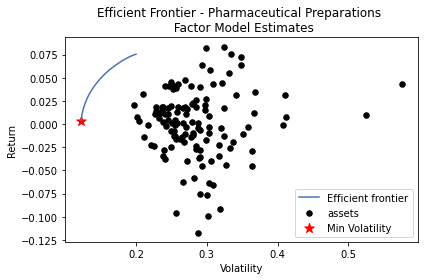

In [24]:
ef1 = EfficientFrontier(mu_Pharm, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - Pharmaceutical Preparations \n Factor Model Estimates")
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Returns_Pharmaceutical_Preparations.png', dpi=200, bbox_inches='tight')
plt.show()

##### Min Volatility Portfolio

###### Performance

In [25]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.4%
Annual volatility: 12.3%
Sharpe Ratio: -0.13


###### Weights

In [26]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Pharmaceutical_Preparations.csv", index = False)

In [27]:
pd.read_csv("data/min_vol_factor_model_Pharmaceutical_Preparations.csv")

,Company_Name,Weight
0,"CONCERT PHARMACEUTICALS, INC.",0.02974
1,NATURES SUNSHINE PRODUCTS INC,0.13263
2,"PACIRA PHARMACEUTICALS, INC.",0.03613
3,"FORTRESS BIOTECH, INC.",0.00586
4,ARENA PHARMACEUTICALS INC,0.08524
5,ZOETIS INC.,0.11746
6,"TELIGENT, INC.",0.08129
7,XOMA CORP,0.05504
8,"ACLARIS THERAPEUTICS, INC.",0.05895
9,PROGENICS PHARMACEUTICALS INC,0.08582


### Results for the Other 4 Industries

In [28]:
SIC_list = [7372, 1311, 6798, 6022]
SIC_desc = ['Prepackaged Software (mass reproduction of software)', 'Crude Petroleum and Natural Gas', 
           'Real Estate Investment Trusts', 'State Commercial Banks (commercial banking)']

#### Prepackaged Software (mass reproduction of software)

In [29]:
SIC = SIC_list[0]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

LR = LinearRegression()

for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

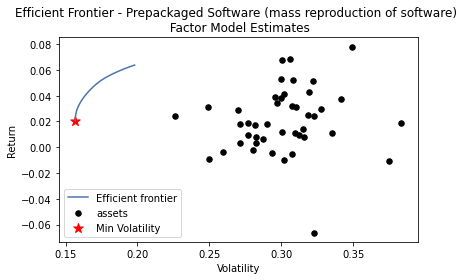

In [30]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
#plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png', dpi=200, bbox_inches='tight')
#plt.show()

![Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png](images/Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png)

##### Min Volatility Portfolio

###### Performance

In [31]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 2.1%
Annual volatility: 15.7%
Sharpe Ratio: 0.00


###### Weights

In [32]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Prepackaged_Software.csv", index = False)

In [33]:
pd.read_csv("data/min_vol_factor_model_Prepackaged_Software.csv")

,Company_Name,Weight
0,APPFOLIO INC,0.01773
1,ELLIE MAE INC,0.00437
2,ANSYS INC,0.06834
3,NATIONAL INSTRUMENTS CORP,0.02466
4,"2U, INC.",0.19685
5,"ENDURANCE INTERNATIONAL GROUP HOLDINGS, INC.",0.11290
6,INTELLIGENT SYSTEMS CORP,0.01948
7,GSE SYSTEMS INC,0.00779
8,MICROSTRATEGY INC,0.13768
9,SPS COMMERCE INC,0.01852


#### Crude Petroleum and Natural Gas
When we conduct the same analysis, there is no weight shown. Efficient frontier cannot be found.

In [34]:
SIC = SIC_list[1]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

mu_sample = mu[LIST]
# get the outliers
outlier = mu_sample[mu_sample>1].index
mu_sample = mu_sample.drop(outlier)
LIST = mu_sample.index

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

LR = LinearRegression()

for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

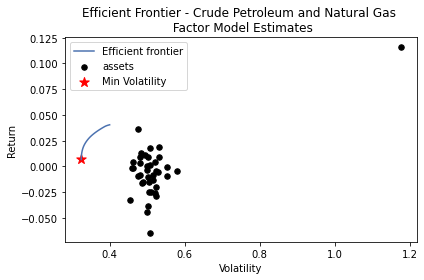

In [35]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
#plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_Crude_Petroleum_and_Natural_Gas.png', dpi=200, bbox_inches='tight')
#plt.show()

![Efficient_Frontier_Factor_Model_Estimates_Crude_Petroleum_and_Natural_Gas.png](images/Efficient_Frontier_Factor_Model_Estimates_Crude_Petroleum_and_Natural_Gas.png)

##### Min Volatility Portfolio

###### Performance

In [36]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.7%
Annual volatility: 32.4%
Sharpe Ratio: -0.04


###### Weights

In [37]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Crude_Petroleum_and_Natural_Gas.csv", index = False)

In [38]:
pd.read_csv("data/min_vol_factor_model_Crude_Petroleum_and_Natural_Gas.csv")

,Company_Name,Weight
0,KOSMOS ENERGY LTD.,0.14627
1,CALLON PETROLEUM CO,0.07632
2,CONTANGO OIL & GAS CO,0.04169
3,CALIFORNIA RESOURCES CORP,0.16181
4,SM ENERGY CO,0.07055
5,ABRAXAS PETROLEUM CORP,0.02884
6,"DORCHESTER MINERALS, L.P.",0.02716
7,GULFPORT ENERGY CORP,0.00625
8,ANTERO RESOURCES CORP,0.08452
9,"WPX ENERGY, INC.",0.03380


#### Real Estate Investment Trusts

In [39]:
SIC = SIC_list[2]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

mu_sample = mu[LIST]
# get the outliers
outlier = mu_sample[mu_sample>1].index
mu_sample = mu_sample.drop(outlier)
LIST = mu_sample.index

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

LR = LinearRegression()

for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

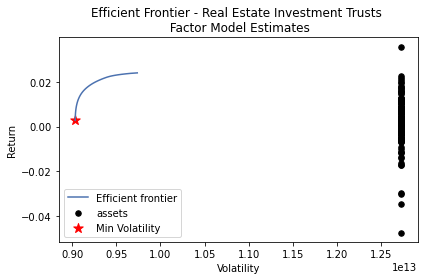

In [40]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
#plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png](images/Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png)

##### Min Volatility Portfolio

###### Performance

In [41]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.3%
Annual volatility: 903532688033803.5%
Sharpe Ratio: -0.00


###### Weights

In [42]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Real_Estate_Investment_Trusts.csv", index = False)

In [43]:
pd.read_csv("data/min_vol_factor_model_Real_Estate_Investment_Trusts.csv")

,Company_Name,Weight
0,EXTRA SPACE STORAGE INC.,0.00781
1,WHITESTONE REIT,0.00781
2,SL GREEN REALTY CORP,0.00781
3,"OWENS REALTY MORTGAGE, INC.",0.00781
4,"AMERICAN ASSETS TRUST, INC.",0.00781
...,...,...
123,CUBESMART,0.00781
124,AVALONBAY COMMUNITIES INC,0.00781
125,WEINGARTEN REALTY INVESTORS /TX/,0.00781
126,"GAMING & LEISURE PROPERTIES, INC.",0.00781


#### State Commercial Banks (commercial banking)

In [44]:
SIC = SIC_list[3]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

LR = LinearRegression()

for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

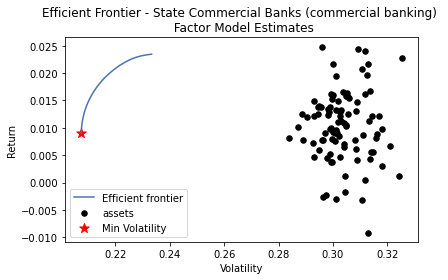

In [45]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))


fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
#plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png](images/Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png)

##### Min Volatility Portfolio

###### Performance

In [46]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.9%
Annual volatility: 20.8%
Sharpe Ratio: -0.05


###### Weights

In [47]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_State_Commercial_Banks.csv", index = False)

In [48]:
pd.read_csv("data/min_vol_factor_model_State_Commercial_Banks.csv")

,Company_Name,Weight
0,HEARTLAND FINANCIAL USA INC,0.02923
1,WEST BANCORPORATION INC,0.02431
2,ENTERPRISE FINANCIAL SERVICES CORP,0.01804
3,"TRISTATE CAPITAL HOLDINGS, INC.",0.01571
4,HOWARD BANCORP INC,0.04462
5,"ATLANTIC CAPITAL BANCSHARES, INC.",0.04742
6,HILLTOP HOLDINGS INC.,0.01095
7,"BANKWELL FINANCIAL GROUP, INC.",0.00512
8,REPUBLIC BANCORP INC /KY/,0.01015
9,"EAGLE BANCORP MONTANA, INC.",0.01243
